In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
if 'cvxopt' not in installedPackages :
    !pip install cvxopt==1.2.5

## 載入相關套件

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#平均數變異數所需的優化套件
import cvxopt as opt
from cvxopt import blas, solvers

In [3]:
import yfinance as yf

## 下載股票和債券以及黃金等資產股價歷史資料

In [4]:
ticker = ('IVW','IVE','IWN','IWO','EFA','EEM','IEF','TLT','IAU')
start = '2010-01-01'

data = yf.download(ticker,start)

[*********************100%***********************]  9 of 9 completed


In [5]:
data = data['Adj Close']

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
missing_fractions = data.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

data.drop(labels=drop_list, axis=1, inplace=True)
data.shape

(3109, 9)

In [8]:
data.head()

,EEM,EFA,IAU,IEF,IVE,IVW,IWN,IWO,TLT
Date,,,,,,,,,
2009-12-31,32.515163,38.690617,21.474001,69.907776,39.906944,12.215596,45.769733,61.861385,65.043221
2010-01-04,33.463196,39.705475,21.978001,70.081367,40.546844,12.396757,46.976276,63.433575,64.985344
2010-01-05,33.706089,39.740479,21.954000,70.389107,40.765167,12.405184,46.802788,63.270008,65.405037
2010-01-06,33.776604,39.908447,22.326000,70.105019,40.863033,12.405184,46.708145,63.379051,64.529480
2010-01-07,33.580723,39.754471,22.181999,70.105019,41.216866,12.396757,47.260162,63.542679,64.638000


## 繪製資產間的相關係數矩陣

<AxesSubplot:>

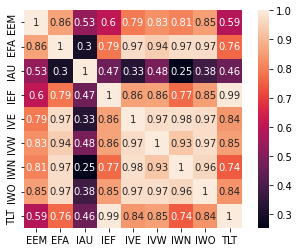

In [9]:
import seaborn as sns
sns.heatmap(data.corr(), vmax=1, square=True,annot=True)

## 將資料分為訓練組和測試組

In [10]:
X= data.copy('deep')
row= len(X)
train_len = int(row*.8)

In [11]:
X_train = X.head(train_len)
X_test = X.tail(row-train_len)

In [12]:
returns = X_train.pct_change().dropna() #計算資料的報酬變動
returns_test=X_test.pct_change().dropna()

In [13]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [14]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([6.        , 7.        , 0.23890125, 2.        ])

## 繪製資產風險分層圖

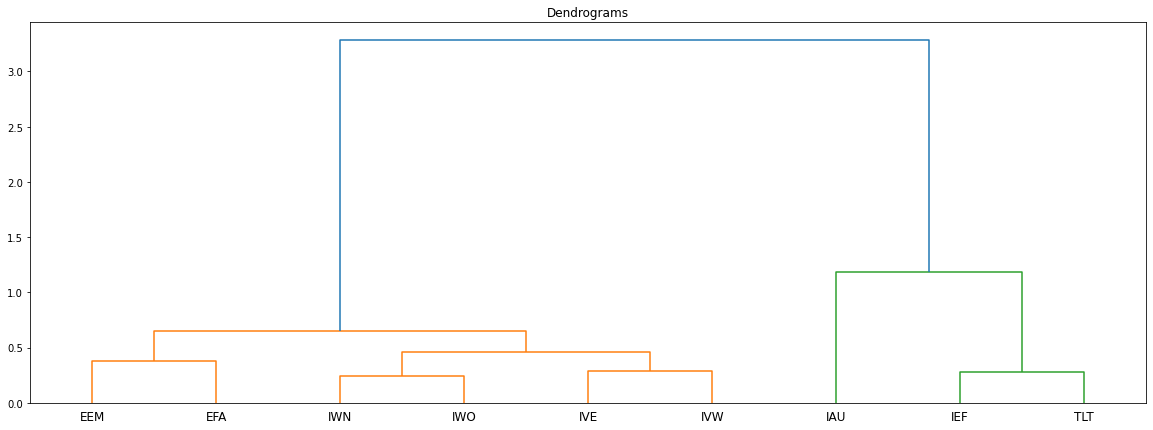

In [15]:
plt.figure(figsize=(20, 7))
plt.title("Dendrograms")
dendrogram(link,labels = X.columns)
plt.show()

In [16]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [17]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [18]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [19]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [20]:
portfolios = get_all_portfolios(returns)

## 兩種投資組合標的資產權重比較

In [21]:
portfolios

,MVP,HRP
EEM,0.015063,0.045280
EFA,0.030651,0.063785
IAU,0.020779,0.133352
IEF,0.756661,0.544287
IVE,0.080910,0.035155
IVW,0.041550,0.034710
IWN,0.029649,0.022102
IWO,0.021938,0.018980
TLT,0.002798,0.102348


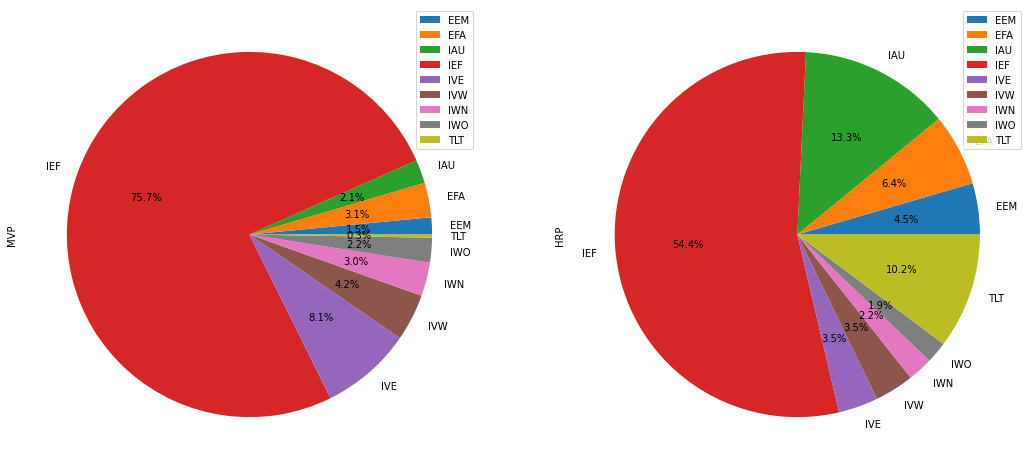

In [47]:
fig, (ax1, ax2) 
ax1.pie(portfolios.iloc[:,0], );
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1]);
ax2.set_title('HRP',fontsize = 30)


portfolios.plot.pie(subplots=True, figsize=(18, 10),legend =True, autopct='%1.1f%%');

In [23]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<AxesSubplot:title={'center':'Out Of Sample Results'}, xlabel='Date'>

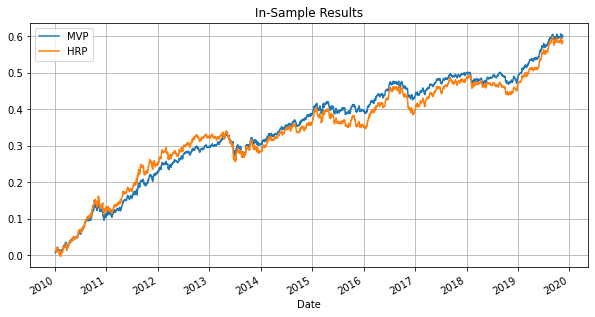

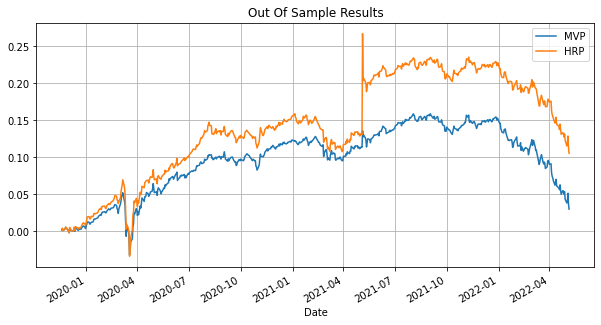

In [24]:
Insample_Result.cumsum().plot(figsize=(10, 5), title ="In-Sample Results",grid=True)
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title ="Out Of Sample Results",grid=True)

## 樣本內測試結果

In [41]:
stddev = Insample_Result.std() * np.sqrt(252)
sharpe_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharpe_ratio = sharpe_ratio))
Results

,stdev,sharpe_ratio
MVP,0.043424,1.407556
HRP,0.053588,1.111548


## 樣本外的測試結果

In [26]:
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharpe_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharpe_ratio_oos = sharpe_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
MVP,0.064416,0.187807
HRP,0.120264,0.355328


In [27]:
portfolios

,MVP,HRP
EEM,0.015063,0.045280
EFA,0.030651,0.063785
IAU,0.020779,0.133352
IEF,0.756661,0.544287
IVE,0.080910,0.035155
IVW,0.041550,0.034710
IWN,0.029649,0.022102
IWO,0.021938,0.018980
TLT,0.002798,0.102348


In [28]:
backtest = data.pct_change()

## 建立兩種投資組合配置

In [29]:
backtest['HRP'] = sum([backtest['EEM'] * 0.045180, backtest['IWN'] * 0.022043, backtest['IWO'] * 0.018929, backtest['EFA'] * 0.063606, backtest['IVW'] * 0.034618, backtest['IVE'] *0.035065,backtest['IEF'] * 0.544846,backtest['IAU'] * 0.133274,backtest['TLT'] * 0.102438])

In [30]:
backtest['MVP'] = sum([backtest['EEM'] * 0.014954, backtest['IWN'] * 0.029530, backtest['IWO'] * 0.021834, backtest['EFA'] * 0.030523, backtest['IVW'] * 0.034618, backtest['IVE'] *0.081110,backtest['IEF'] * 0.756902 ,backtest['IAU'] * 0.020828,backtest['TLT'] * 0.002777])

In [31]:
backtest.dropna()

,EEM,EFA,IAU,IEF,IVE,IVW,IWN,IWO,TLT,HRP,MVP
Date,,,,,,,,,,,
2010-01-04,0.029157,0.026230,0.023470,0.002483,0.016035,0.014830,0.026361,0.025415,-0.000890,0.009513,0.006750
2010-01-05,0.007259,0.000882,-0.001092,0.004391,0.005384,0.000680,-0.003693,-0.002579,0.006458,0.003375,0.003749
2010-01-06,0.002092,0.004227,0.016945,-0.004036,0.002401,0.000000,-0.002022,0.001723,-0.013387,-0.000876,-0.002406
2010-01-07,-0.005799,-0.003858,-0.006450,0.000000,0.008659,-0.000679,0.011818,0.002582,0.001682,-0.000605,0.000750
2010-01-08,0.007933,0.007923,0.004869,0.001238,0.001826,0.004588,0.005507,0.004004,-0.000447,0.002560,0.001954
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02,-0.001416,-0.002477,-0.018591,-0.007450,-0.000203,0.013028,0.003225,0.017855,-0.017334,-0.007681,-0.005251
2022-05-03,0.007325,0.007449,0.002827,0.001177,0.006083,0.003252,0.014668,0.002581,0.006742,0.003212,0.002401
2022-05-04,0.010791,0.017541,0.009867,0.006468,0.026738,0.032709,0.026470,0.027139,0.005510,0.010174,0.010489


In [32]:
import pyfolio as pf

Start date,2009-12-31
End date,2022-05-06
Total months,148
,Backtest
Annual return,5.518%
Cumulative returns,93.986%
Annual volatility,7.197%
Sharpe ratio,0.78
Calmar ratio,0.36
Stability,0.93
Max drawdown,-15.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.30,2021-05-05,2022-05-06,NaT,NaN
1,9.91,2020-03-06,2020-03-18,2020-04-24,36
2,8.19,2013-05-02,2013-07-05,2014-06-24,299
3,7.68,2016-09-06,2016-12-15,2017-08-03,238
4,5.67,2015-02-02,2016-01-11,2016-03-29,302


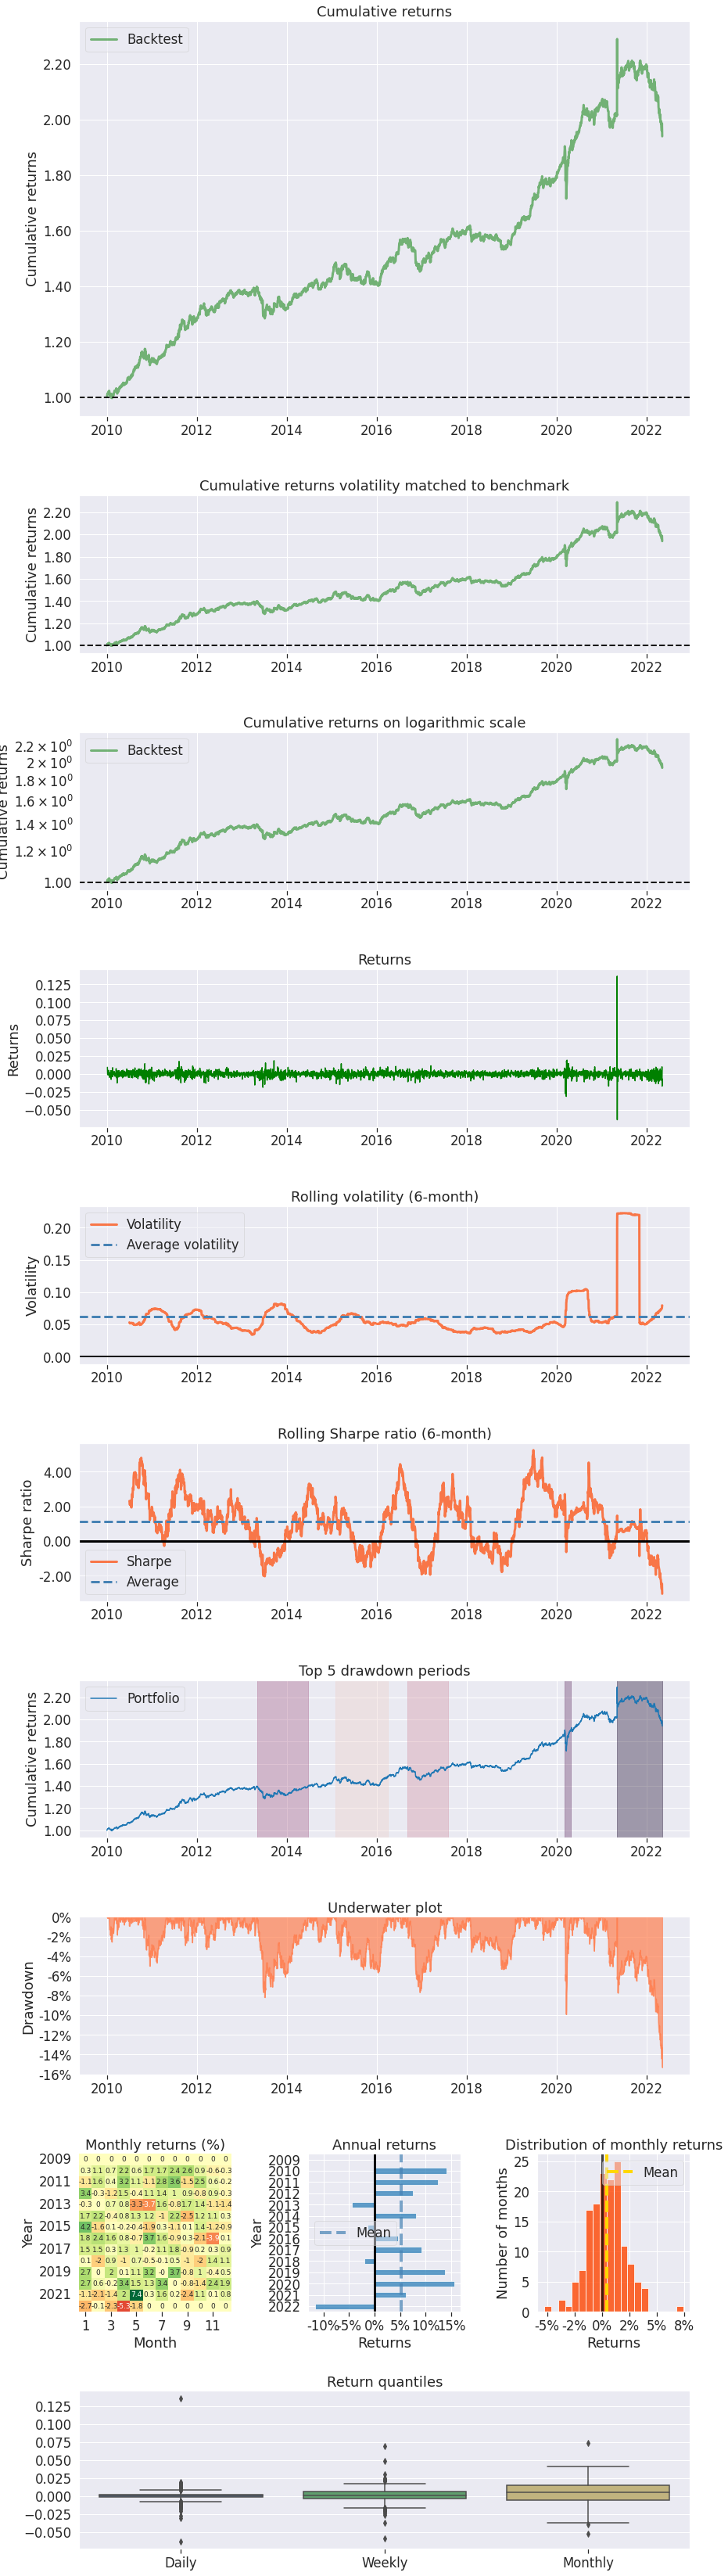

In [33]:
pf.create_returns_tear_sheet(backtest['HRP'])

Start date,2009-12-31
End date,2022-05-06
Total months,148
,Backtest
Annual return,5.041%
Cumulative returns,83.445%
Annual volatility,4.782%
Sharpe ratio,1.05
Calmar ratio,0.41
Stability,0.96
Max drawdown,-12.151%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.15,2021-08-03,2022-05-06,NaT,NaN
1,8.01,2020-03-06,2020-03-18,2020-04-27,37
2,6.24,2013-05-02,2013-09-05,2014-05-01,261
3,5.24,2010-11-04,2010-12-15,2011-05-09,133
4,5.07,2016-09-07,2016-12-15,2017-06-02,193


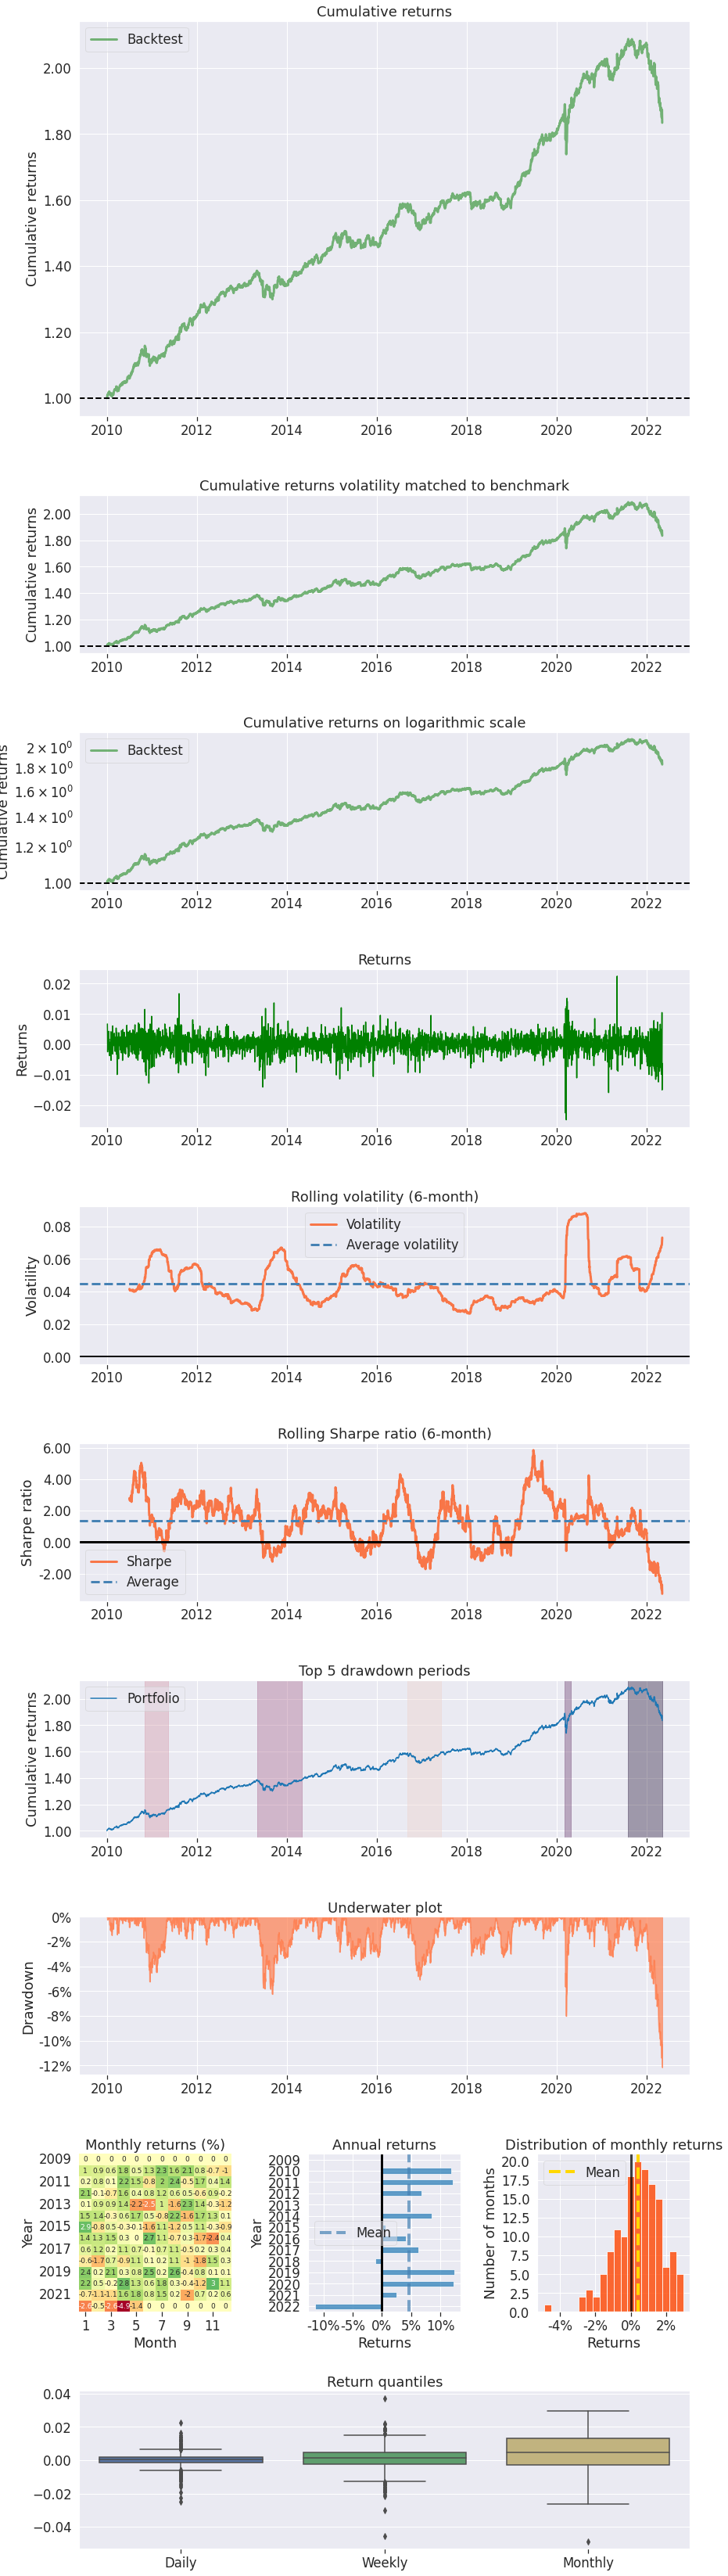

In [34]:
pf.create_returns_tear_sheet(backtest['MVP'])

In [35]:
backtest_rtns = (backtest+1).cumprod() - 1

## 將兩種投資組合累積報酬比較

Text(0.5, 1.0, 'Portfolio compare')

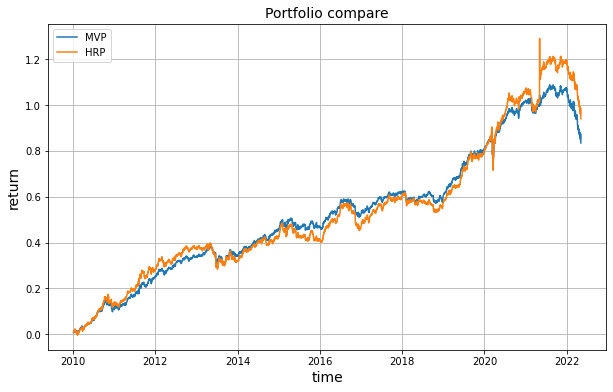

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(backtest_rtns[['MVP','HRP']])
plt.legend(backtest_rtns[['MVP','HRP']])
plt.ylabel('return',fontsize='14')
plt.xlabel('time',fontsize='14')
plt.title('Portfolio compare',fontsize='14')